Импорт нужных модулей.

In [10]:
from google.colab import drive
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential, Model
import numpy as np
import pandas as pd
import os
import tensorflow.keras.backend as K
from sklearn.metrics import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
from matplotlib import pyplot as plt 

In [ ]:
drive.mount('/content/drive')

Анализ датасета.
Для этого, в основном, будут использоваться инструменты pandas dataframe. А также библиотек sklearn и seaborn.

===========================================================

Dataset Analysis
Main tool is pandas dataframe, sklearn and seaborn as instrument for nice heatmap.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Загрузка датасета по частям с дальнейшей конкатенацией. 
df1=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")#,nrows = 50000
df2=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Monday-WorkingHours.pcap_ISCX.csv")
df5=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Tuesday-WorkingHours.pcap_ISCX.csv")
df8=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Wednesday-workingHours.pcap_ISCX.csv")

#Вывод уникальных признаков типов аттак или benign для каждого датасета. Ожидается DDoS, DoS Types и т.д.
print (df1[' Label'].unique())
print (df2[' Label'].unique())
print (df3[' Label'].unique())
print (df4[' Label'].unique())
print (df5[' Label'].unique())
print (df6[' Label'].unique())
print (df7[' Label'].unique())
print (df8[' Label'].unique(), "\n")

#Конкатенация и общая информация о наборе данных
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df= pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8
data = df.copy() #Датафрейм копируем в дату для дальнейших операций
data.info()



['BENIGN' 'DDoS']
['BENIGN' 'PortScan']
['BENIGN' 'Bot']
['BENIGN']
['BENIGN' 'Infiltration']
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
['BENIGN' 'FTP-Patator' 'SSH-Patator']
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Len

<h4>Необязательный шаг.</h4>

Тепловая карта для сырого датасета. Благодаря ней можно понять основные недостатки сырого датасета и с ними работать в дальнейшем препроцессинге.

In [4]:
#fig= plt.figure(figsize=(70,70))
#sns.heatmap(data.corr(), annot=True)

<Figure size 5040x5040 with 0 Axes>

Необходимо отбросить пустые значения из изначального датасета.

In [5]:
#Подтягиваем из датасета
deleteCol = []
for column in data.columns:
    if data[column].isnull().values.any():
        deleteCol.append(column)
for column in deleteCol:
    data.drop([column],axis=1,inplace=True)

deleteCol = []
for column in data.columns:
    if column == ' Label':
        continue
    elif data[column].dtype==np.object:
        deleteCol.append(column)
for column in deleteCol:
    data.drop(column,axis=1,inplace=True)

data[' Flow Duration'].unique()

In [ ]:
for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64 

Missing values: 0 

Missing values: 2867 

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot             

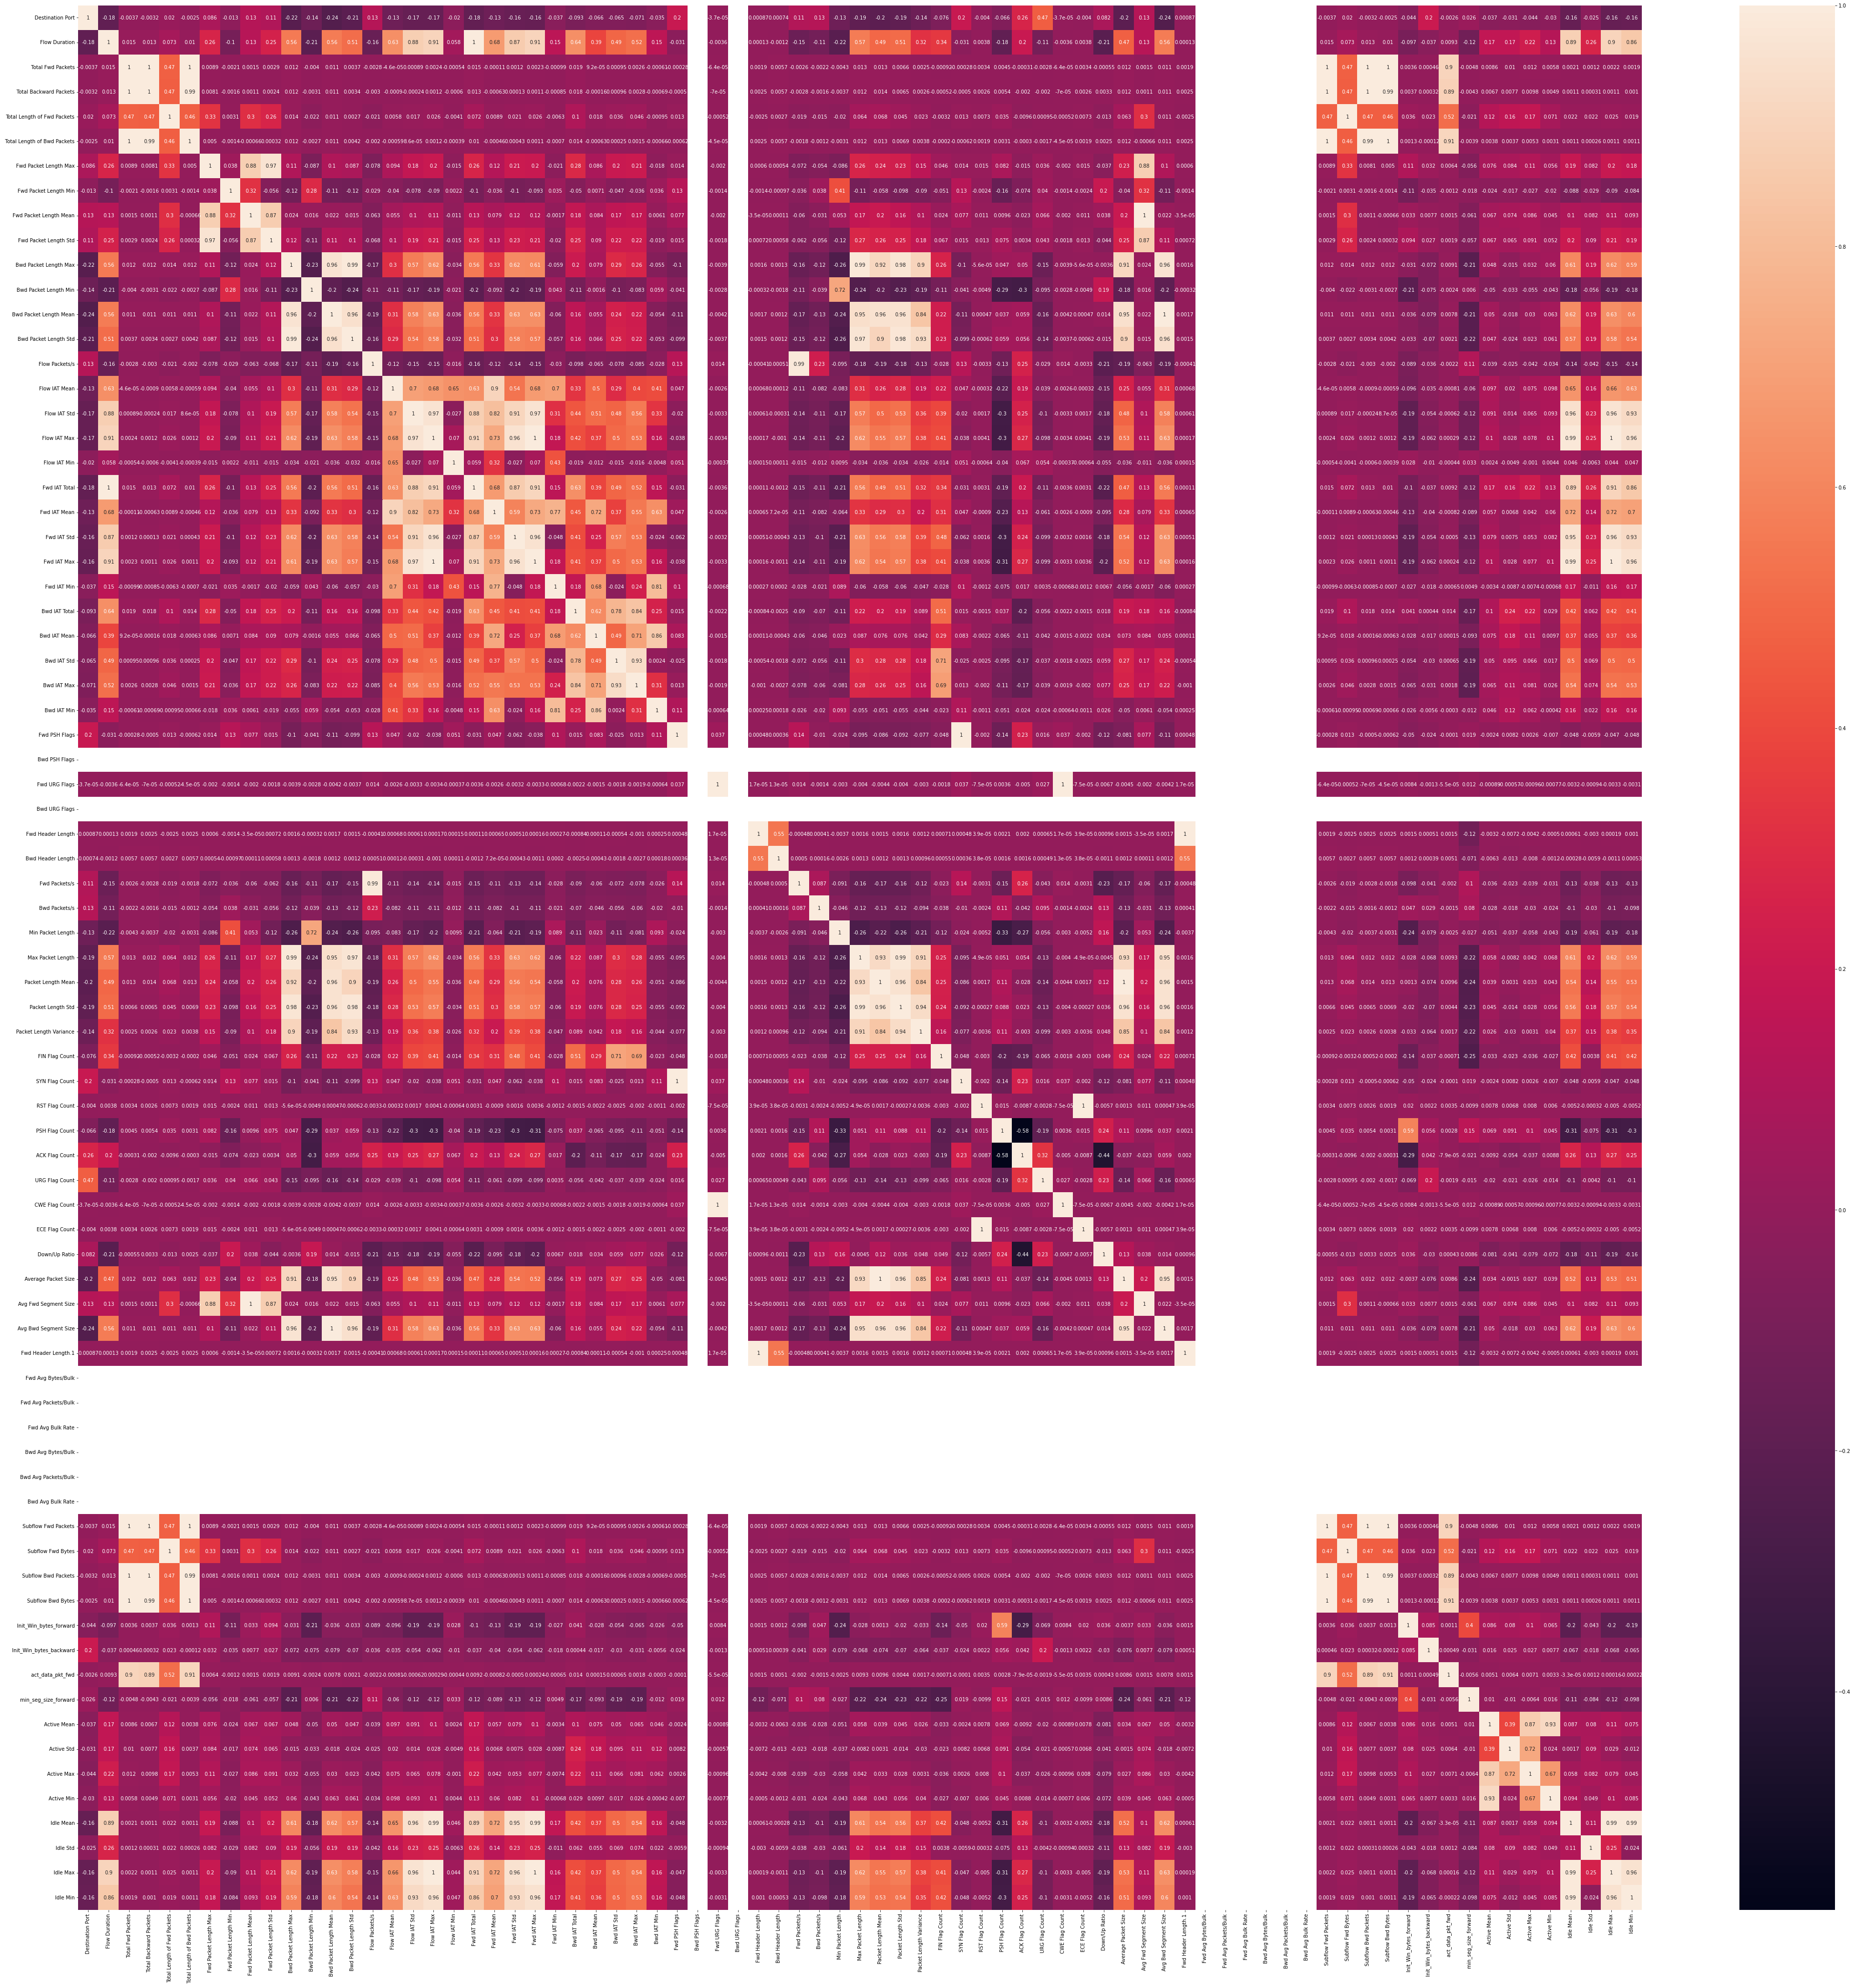

In [6]:
print(data[" Label"].value_counts(), "\n")

# Check for missing data
print(f"Missing values: {data.isnull().sum().sum()}", "\n")

# Check for infinite values, replace with NAN so it is easy to remove them
data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {data.isnull().sum().sum()}", "\n")

print(data[' Label'].value_counts(), "\n")

benign = data[data[' Label'] == 'BENIGN'].sample(frac=0.1).reset_index(drop=True)
attack = data[data[' Label'] != 'BENIGN']
data = pd.concat([attack, benign])
#print(data[' Label'].value_counts(), "\n")

ddos = data[data[' Label'] == 'DDoS'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'DDoS']
data = pd.concat([attack, ddos])
#print(data[' Label'].value_counts(), "\n")

PortScan = data[data[' Label'] == 'PortScan'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'PortScan']
data = pd.concat([attack, PortScan])
#print(data[' Label'].value_counts(), "\n")

Bot = data[data[' Label'] == 'Bot'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'Bot']
data = pd.concat([attack, Bot])
#print(data[' Label'].value_counts(), "\n")

Infiltration = data[data[' Label'] == 'Infiltration'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'Infiltration']
data = pd.concat([attack, Infiltration])
#print(data[' Label'].value_counts(), "\n")

BF = data[data[' Label'] == 'Web Attack � Brute Force'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'Web Attack � Brute Force']
data = pd.concat([attack, BF])
#print(data[' Label'].value_counts(), "\n")

XSS = data[data[' Label'] == 'Web Attack � XSS'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'Web Attack � XSS']
data = pd.concat([attack, XSS])
#print(data[' Label'].value_counts(), "\n")

SQLI = data[data[' Label'] == 'Web Attack � Sql Injection'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'Web Attack � Sql Injection']
data = pd.concat([attack, SQLI])
#print(data[' Label'].value_counts(), "\n")

FTPP = data[data[' Label'] == 'FTP-Patator'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'FTP-Patator']
data = pd.concat([attack, FTPP])
#print(data[' Label'].value_counts(), "\n")

SSHP = data[data[' Label'] == 'SSH-Patator'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'SSH-Patator']
data = pd.concat([attack, SSHP])
#print(data[' Label'].value_counts(), "\n")

DOSs = data[data[' Label'] == 'DoS slowloris'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS slowloris']
data = pd.concat([attack, DOSs])
#print(data[' Label'].value_counts(), "\n")

DOShttp = data[data[' Label'] == 'DoS Slowhttptest'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS Slowhttptest']
data = pd.concat([attack, DOShttp])
#print(data[' Label'].value_counts(), "\n")

Hulk = data[data[' Label'] == 'DoS Hulk'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS Hulk']
data = pd.concat([attack, Hulk])
#print(data[' Label'].value_counts(), "\n")

GY = data[data[' Label'] == 'DoS GoldenEye'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS GoldenEye']
data = pd.concat([attack, GY])
#print(data[' Label'].value_counts(), "\n")

HB = data[data[' Label'] == 'Heartbleed'].sample(frac=0.5).reset_index(drop=True)
attack = data[data[' Label'] != 'Heartbleed']
data = pd.concat([attack, HB])
print(data[' Label'].value_counts(), "\n")

y = data[' Label']
X = data.drop([' Label'],axis=1)



fig= plt.figure(figsize=(70,70))
sns.heatmap(X.corr(), annot=True)

In [8]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506133 entries, 0 to 5
Data columns (total 77 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             506133 non-null  int32  
 1    Flow Duration                506133 non-null  int32  
 2    Total Fwd Packets            506133 non-null  int32  
 3    Total Backward Packets       506133 non-null  int32  
 4   Total Length of Fwd Packets   506133 non-null  int32  
 5    Total Length of Bwd Packets  506133 non-null  int32  
 6    Fwd Packet Length Max        506133 non-null  int16  
 7    Fwd Packet Length Min        506133 non-null  int16  
 8    Fwd Packet Length Mean       506133 non-null  float32
 9    Fwd Packet Length Std        506133 non-null  float32
 10  Bwd Packet Length Max         506133 non-null  int16  
 11   Bwd Packet Length Min        506133 non-null  int16  
 12   Bwd Packet Length Mean       506133 non-null  fl

AttributeError: ignored

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

feature = pd.DataFrame()
n = len(featureScores['Specs'])
for i in featureScores.nlargest(n//2,'Score')['Specs']:
        feature[i] = data[i]
feature[' Label'] = data[' Label']



fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True)

ValueError: ignored

Объявление переменных

In [ ]:
path = '/content/drive/MyDrive/CICIDS2017/data_nn'
data = []
target = []

Чтение датасета.

In [ ]:
for name in os.listdir(path):
    file = pd.read_csv(os.path.join(path, name))
    print ('Types of marks in', name, ":", file[' Label'].unique())
    for n, i in file.iterrows():
        a = []
        for j in i[:-1]:
          a.append(j)
        data.append(a) 
        target.append(0 if i[-1] == 'BENIGN' else 1) 
del file


Types of marks in Wednesday-workingHours.pcap_ISCX.csv : ['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']
Types of marks in Tuesday-WorkingHours.pcap_ISCX.csv : ['BENIGN' 'FTP-Patator' 'SSH-Patator']
Types of marks in Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv : ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
Types of marks in Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv : ['BENIGN' 'Infiltration']
Types of marks in Monday-WorkingHours.pcap_ISCX.csv : ['BENIGN']
Types of marks in Friday-WorkingHours-Morning.pcap_ISCX.csv : ['BENIGN' 'Bot']
Types of marks in Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv : ['BENIGN' 'PortScan']
Types of marks in Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv : ['BENIGN' 'DDoS']


Обработка данных

In [ ]:
data = np.array(data)
target = np.array(target)
print(data.shape, target.shape)


(2830743, 78) (2830743,)


Подготовка данных для нормализации

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.nan_to_num(data).astype(float))
data = scaler.transform(np.nan_to_num(data).astype(float))
data = data.reshape(data.shape[0], 78, 1)
 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
datax = data.reshape(data.shape[0], 78)
ax = sns.heatmap(datax) 

Сохранение нормализатора

In [ ]:
pickle.dump(scaler, open('/content/drive/MyDrive/CICIDS2017/devtest/scaler.pkl', 'wb'))

Моделирование нейросети

In [ ]:
lstm = Sequential()
lstm.add(Input((78, 1)))
lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
for i in range(3):
  lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
lstm.add(Flatten())
lstm.add(Dense(2,activation = 'softmax'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Тренировка нейросети

In [ ]:
lstm.fit(data, to_categorical(target), epochs=2, batch_size=256, verbose=1)

lstm.save('/content/drive/MyDrive/CICIDS2017/devtest/lstm.h5')

Получение данных от нейросети

In [ ]:
y_pred1 = lstm.predict(data, batch_size=1024)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик и количества пакетов с атакой и без

In [ ]:
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(target, y_pred))
print('Confussion Matrix', confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Alghorythm marked', count_list[1], 'as attack and', count_list[1], "packets as benign")

Чтение датасета для второй нейросети. KNN

In [ ]:
data = []
target = []
last = []
for name in os.listdir(path):
    file = pd.read_csv(os.path.join(path, name))
    for n, i in file.iterrows():
        if not i[-1] in last:
            last.append(i[-1])
        if last.index(i[-1]) != 0:
          a = []
          for j in i[:-1]:
              a.append(j)
          data.append(a)
          target.append(last.index(i[-1])-1)
del file
del last[0]

Обработка

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78)
print(data.shape, target.shape)

Загрузка нормализатора

In [ ]:
scaler = pickle.load(open('/content/drive/MyDrive/scaler.pkl', 'rb'))

Нормализация данных для второй нейросети

In [ ]:
data = scaler.transform(np.nan_to_num(data).astype(float))

Моделирование второй нейросети

In [ ]:
knn = Sequential()
knn.add(InputLayer((78,)))
knn.add(BatchNormalization())
knn.add(Dense(128, activation='relu'))
knn.add(Dense(128, activation='relu'))
knn.add(Dense(14, activation='softmax'))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
knn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

Тренировка второй нейросети

In [ ]:
knn.fit(data.astype(float), target, epochs=10, batch_size=256, verbose=1)

knn.save('/content/drive/MyDrive/knn.h5')

Получение данных со второй нейросети

In [ ]:
y_pred1 = knn.predict(data)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик и количество классов

In [ ]:
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(to_categorical(target), np.nan_to_num(y_pred1), multi_class='ovr'))
print('матрица неточностей', confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Классы:')
for i in count_list:
  print(last[i], count_list[i])

-

-

-

Здесь начинается проверка нейросети

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

Загрузка заранее обученной нейросети

In [ ]:
lstm = load_model('/content/drive/MyDrive/lstm.h5')
knn = load_model('/content/drive/MyDrive/knn.h5')

Загрузка данных для тестирования нейросети

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/net/Tuesday-WorkingHours.pcap_ISCX.csv')
data = []
target = []

for n, i in file.iterrows():
        a = []
        for j in i[:-1]:
          a.append(j)
        data.append(a)
        target.append(last.index(i[-1]))

Обработка данных

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78, 1)
print(data.shape, target.shape)

Проверка нейросети

In [ ]:
model.evaluate(data, target)

Предсказание нейросети

In [ ]:
pred = model.predict(data)

Определение класса предсказанния нейросети

In [ ]:
print(last[np.argmax(pred[5])])